<a href="https://colab.research.google.com/github/ManavFCB/Crowd-Counting/blob/master/Crowd_Counting_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
from google.colab import drive
import pandas as pd
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

In [170]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
path = '/content/gdrive/MyDrive/fdst/train_data'  #replace with test_data for performing svd on test data

In [ ]:
#Decided on the on the rank of the matrix S. Found that 150 works best. However this has to backed with mathematical evidence.
rank = 150
for root, dirs, files in os.walk(path):
    print(root)
    if 'svd' not in root and 'svd' not in dirs:
        for file in files:
            if 'jpg' in file and "_" not in file:
                img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)  #don't require them to be RGB. One channel should work
                U, S, V = np.linalg.svd(img, full_matrices = False)
                reconst_img = np.matmul(np.matmul(U[:, :rank], np.diag(S[:rank])), V[:rank, :])
                if not os.path.isdir(os.path.join(root, "svd_" + str(rank))):
                  print("created:"+os.path.join(root, "svd_" + str(rank)))
                  os.mkdir(os.path.join(root, "svd_" + str(rank)))
                cv2.imwrite(os.path.join(root, "svd_"+ str(rank), file), reconst_img)
    else:
      print("already exists")
      continue

### **Kernel Density Estimation**

**a) generate annotation map for each training frame**

**1. trial on a sample image**

In [ ]:
img = cv2.imread("/content/gdrive/MyDrive/fdst/train_data/91/annotation_map_5/126.jpg", cv2.IMREAD_GRAYSCALE)

In [ ]:
img_json = pd.read_json("/content/gdrive/MyDrive/fdst/train_data/1/001.json")

In [ ]:
annotations = img_json.iloc[2][img_json.columns[0]]

In [ ]:
density_img = np.zeros(img.shape, dtype = 'float32')

In [ ]:
for annotation in annotations:
  x = annotation['shape_attributes']['x']
  y = annotation['shape_attributes']['y']
  width = annotation['shape_attributes']['width']
  height = annotation['shape_attributes']['height']
  density_img[y, x] = 255

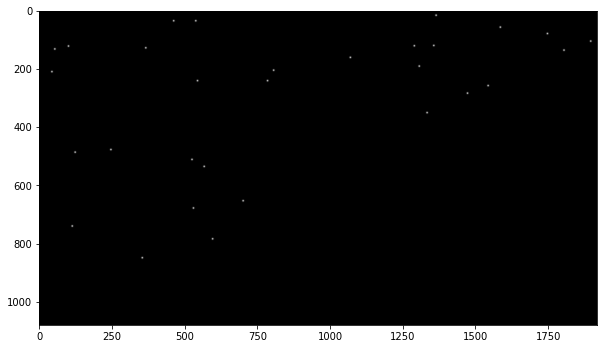

In [ ]:
plt.figure(figsize = (10, 20))
plt.imshow(density_img)
map = gaussian_filter(density_img, sigma = (2, 2), order = 0)
plt.imshow(map, cmap = 'gray')

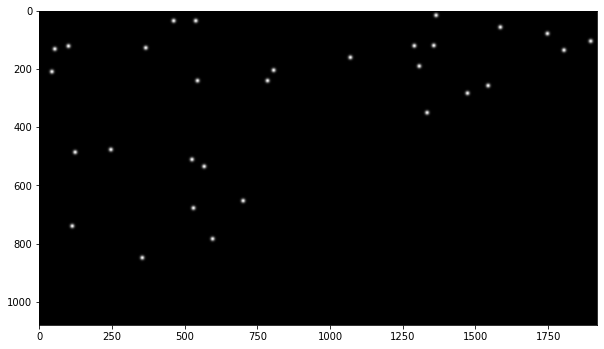

In [ ]:
plt.figure(figsize = (10, 20))
plt.imshow(density_img)
map = gaussian_filter(density_img, sigma = (5, 5), order = 0)
plt.imshow(map, cmap = 'gray')

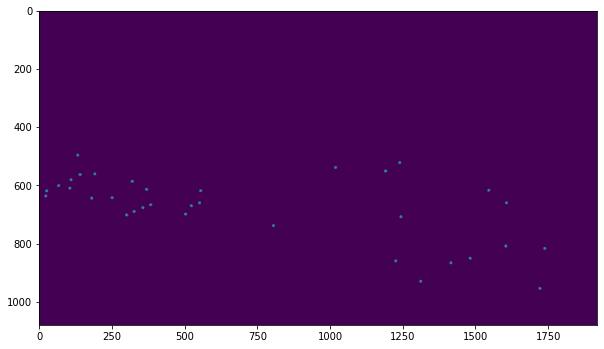

In [ ]:
plt.figure(figsize = (10, 20))
plt.imshow(img)

**2. Generation of the same on all training frames**

In [ ]:
height = 1080
width = 1920
sigmas = [1, 5]
for root, dirs, files in os.walk(path):
    print(root)
    if 'svd_' not in root and 'svd_' not in dirs:
        for file in files:
            if 'json' in file and "_" not in file:
                img_json = pd.read_json(os.path.join(root, file))
                annotations = img_json.iloc[2][img_json.columns[0]]
                annotation_map = np.zeros(img.shape, dtype = 'int')
                for annotation in annotations:
                  x = annotation['shape_attributes']['x']
                  y = annotation['shape_attributes']['y']
                  width = annotation['shape_attributes']['width']
                  height = annotation['shape_attributes']['height']
                  annotation_map[y, x] = 255
                  maps = []
                  maps.append(gaussian_filter(annotation_map, sigma = (1, 1), order = 0))
                  maps.append(gaussian_filter(annotation_map, sigma = (5, 5), order = 0))
                if not os.path.isdir(os.path.join(root, "annotation_map_1")):
                  print("created:"+os.path.join(root, "annotation_map_1"))
                  os.mkdir(os.path.join(root, "annotation_map_1"))
                if not os.path.isdir(os.path.join(root, "annotation_map_5")):
                  print("created:"+os.path.join(root, "annotation_map_5"))
                  os.mkdir(os.path.join(root, "annotation_map_5"))
                img_name = file.replace("json", "jpg")
                cv2.imwrite(os.path.join(root, "annotation_map_1", img_name), maps[0])
                cv2.imwrite(os.path.join(root, "annotation_map_5", img_name), maps[1])
    else:
      print("already exists")
      continue

**Training a CNN to learn the density plots**

**a) Train on sigma = 5**

In [182]:
y_train = []
x_train = []
x_train_resized = []
gt_train_list = []

In [183]:
gt_train = pd.read_csv("/content/gdrive/MyDrive/fdst/train_data/ground_truth_train.csv")
gt_test = pd.read_csv("/content/gdrive/MyDrive/fdst/test_data/ground_truth_test.csv")

def imgToGT(df):
  dic = {}
  length = len(df)
  for i in range(length):
    dic[df.iloc[i, 0]] = df.iloc[i, 1]
  return dic

gt_train_dic = imgToGT(gt_train)
gt_test_dic = imgToGT(gt_test)

In [184]:
path = "/content/gdrive/MyDrive/fdst/train_data"
cnt = 0
for root, dirs, files in os.walk(path):
  if "annotation_map_5" in root:
    for file in files:
      if cnt < 4500:
        annot_img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
        annot_img_resize = cv2.resize(annot_img, (960, 540))
        parent_dir = os.path.dirname(root)
        svd_dir = os.path.join(parent_dir, 'svd_150')
        if os.path.join(parent_dir, file) in gt_train_dic.keys():
          gt = gt_train_dic[os.path.join(parent_dir, file)]
          train_img = cv2.imread(os.path.join(svd_dir, file), cv2.IMREAD_GRAYSCALE)
          if train_img is not None:
            train_img_resize = cv2.resize(train_img, (960, 540))
            x_train_resized.append(train_img_resize)
            _, train_img_resize = cv2.threshold(train_img_resize, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            y_train.append(annot_img_resize)
            x_train.append(train_img_resize)
            gt_train_list.append(gt)
            cnt += 1
      else:
        break


KeyboardInterrupt: ignored

In [185]:
len(x_train)

4311

In [187]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [188]:
x_val, y_val, gt_val = x_train[int(0.8 * len(x_train)):len(x_train)], y_train[int(0.8 * len(y_train)):len(y_train)], gt_train_list[int(0.8 * len(gt_train_list)):len(gt_train_list)]
x_train, y_train, gt_train = x_train[:int(0.8 * len(x_train))], y_train[:int(0.8 * len(y_train))], gt_train_list[:int(0.8 * len(gt_train_list))]

In [189]:
x_val_resized = x_train_resized[int(0.8 * len(x_train)):]
x_train_resized = x_train_resized[:int(0.8 * len(x_train))]

In [ ]:
test_path = '/content/gdrive/MyDrive/fdst/test_data/'
test_file_list = []
gt_test_list = []
resized_img = []
cnt = 0
for root, dirs, files in os.walk(test_path):
  if 'svd_150' in root:
    if cnt < 450:
      for file in files:
        img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img, (960, 540))
        _, img_thresh = cv2.threshold(img_resize, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        parent_dir = os.path.dirname(root)
        gt = gt_test_dic[os.path.join(parent_dir, file)]
        test_file_list.append(img_thresh)
        resized_img.append(img_resize)
        gt_test_list.append(gt)
        cnt += 1

In [ ]:
test_file_list = np.array(test_file_list)
gt_test_list = np.array(gt_test_list)

In [175]:
len(x_train)

1200

In [ ]:
def step_decay(epoch):
    step = 16
    num = epoch // step 
    if num % 3 == 0:
        lrate = 1e-3
    elif num % 3 == 1:
        lrate = 1e-4
    else:
        lrate = 1e-5
    return np.float(lrate)

In [ ]:
#using ssim loss as the mse doesn't really capture visual differences very well.
def ssim_loss(target, pred):
  return 1 - tf.reduce_sum(tf.image.ssim(target, pred, 255.0))

In [ ]:
#for annotation_1, first network
def convolute(x, filters, kernel_size = (3, 3), padding = 'same', strides = 1):
  c = tf.keras.layers.Convolution2D(filters, kernel_size, strides = strides, padding = padding)(x)
  n = tf.keras.layers.BatchNormalization()(c)
  a = tf.keras.layers.Activation(activation = 'relu')(n)
  return a

def convencdec():
  f= [64, 128, 512]
  input = tf.keras.layers.Input((540, 960))
  reshape = tf.keras.layers.Reshape((540, 960, 1))(input)
  bn = tf.keras.layers.BatchNormalization()(reshape)
  c1 = convolute(bn, f[0])
  m1 = tf.keras.layers.MaxPool2D((2, 2))(c1)
  c2 = convolute(m1, f[1])
  m2 = tf.keras.layers.MaxPool2D((2, 2))(c2)
  c3 = convolute(m2, f[2])
  up1 = tf.keras.layers.UpSampling2D((2, 2))(c3)
  c5 = convolute(up1, f[1])
  up2 = tf.keras.layers.UpSampling2D((2, 2))(c5)
  c6 = convolute(up2, f[0])
  out = tf.keras.layers.Convolution2D(1, 1, 1, 'same', activation='sigmoid')(c6)
  out = tf.keras.layers.Reshape((540, 960))(out)
  out = out * np.max(y_train)
  return tf.keras.Model(input, out)

In [ ]:
mod = convencdec()
opt = tf.keras.optimizers.SGD(momentum=0.9, nesterov = True)
mod.compile(optimizer=opt, loss = 'mse')

In [168]:
mod.summary()

NameError: ignored

In [ ]:
# pre-train with density maps
mod.fit(y_train, y_train,
                epochs = 20,
                batch_size = 16, 
                validation_data = (y_val, y_val),
                shuffle=True)

Epoch 1/20
125/125 [==============================] - 99s 787ms/step - loss: 5.2057e-04 - val_loss: 4.7921e-04
Epoch 2/20
125/125 [==============================] - 98s 786ms/step - loss: 4.8114e-04 - val_loss: 4.4299e-04
Epoch 3/20
 17/125 [===>..........................] - ETA: 1:19 - loss: 4.5888e-04

KeyboardInterrupt: ignored

In [ ]:
mod.save("/content/gdrive/MyDrive/fdst/fcencdec_1.h5")  #saving the best model

In [ ]:
mod = tf.keras.models.load_model("/content/gdrive/MyDrive/fdst/fcencdec_1.h5")
# for layer in mod.layers[11:]:
#   layer.trainable = False

In [ ]:
mod.compile(optimizer= tf.keras.optimizers.SGD(momentum=0.9, nesterov = True), loss = 'mse')
mod.fit(x_train, y_train,
                epochs = 15,
                batch_size = 16, 
                validation_data = (x_val, y_val),
                shuffle=True)

Epoch 1/15
125/125 [==============================] - 81s 639ms/step - loss: 0.0098 - val_loss: 0.0110
Epoch 2/15
125/125 [==============================] - 80s 637ms/step - loss: 0.0053 - val_loss: 0.0079
Epoch 3/15
125/125 [==============================] - 80s 637ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 4/15
125/125 [==============================] - 80s 637ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 5/15
125/125 [==============================] - 80s 637ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 6/15
125/125 [==============================] - 80s 637ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 7/15
125/125 [==============================] - 80s 637ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 8/15
 14/125 [==>...........................] - ETA: 1:04 - loss: 0.0038

KeyboardInterrupt: ignored

In [ ]:
#unet trial
def conv(x, filters, kernel_size = (3, 3), padding = 'same', strides = 1):
  c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = 'same')(x)
  c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = 'same')(c)
  b = tf.keras.layers.BatchNormalization()(c)
  m = tf.keras.layers.MaxPool2D((2, 2))(b)
  return b, m

def bottleneck(x, filters, kernel_size = (3, 3), padding = 'same', strides = 1):
  c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = 'same')(x)
  c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = 'same')(c)
  b = tf.keras.layers.BatchNormalization()(c)
  return b

def upconv(x, skip, filters, kernel_size = (3, 3), padding = 'same', strides = 1):
  ups = tf.keras.layers.UpSampling2D(2)(x)
  concat = tf.keras.layers.Concatenate()([ups, skip])
  c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = 'same')(concat)
  c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = 'same')(c)
  b = tf.keras.layers.BatchNormalization()(c)
  return b

def unet():
  filters = [16, 64, 128]
  input = tf.keras.layers.Input((540, 960))
  reshape = tf.keras.layers.Reshape((540, 960, 1))(input)
  bn = tf.keras.layers.BatchNormalization()(reshape)
  c1, m1 = conv(bn, filters[0])
  c2, m2 = conv(m1, filters[1])
  c3 = bottleneck(m2, filters[2])
  u1 = upconv(c3, c2, filters[1])
  u2 = upconv(u1, c1, filters[0])
  out = tf.keras.layers.Conv2D(1, 1, padding = 'same', activation = 'sigmoid', dtype = 'float32')(u2)
  out = out * np.max(y_train)
  out = tf.keras.layers.Reshape((540, 960))(out)
  return tf.keras.Model(input, out)

In [ ]:
unet = unet()
unet.compile(optimizer = 'adam', loss = 'mse')
print(unet.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 540, 960)]   0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 540, 960, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 540, 960, 1)  4           reshape[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 540, 960, 16) 160         batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
unet = tf.keras.models.load_model("/content/gdrive/MyDrive/fdst/unet_anmap.h5")
unet.fit(x_train, y_train,
                epochs = 30,
                batch_size = 16, 
                validation_data = (x_val, y_val), 
                shuffle=True)

In [ ]:
unet.save("/content/gdrive/MyDrive/fdst/unet_anmap.h5")

In [ ]:
test_file_list.shape

(450, 540, 960)

In [217]:
pred = unet.predict(x_train[:900], batch_size = 16)
a = pred[850]
a = np.reshape(a, (a.shape[0], a.shape[1]))

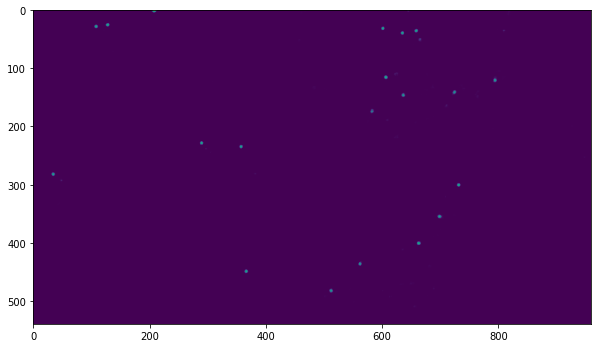

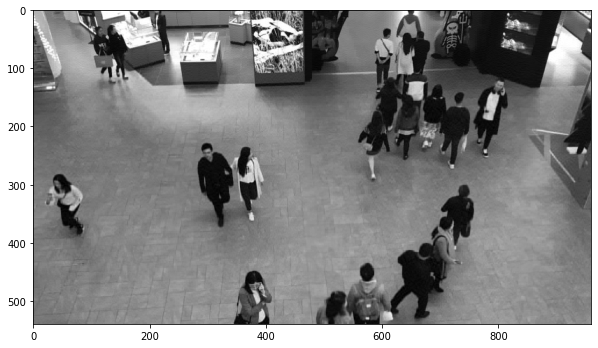

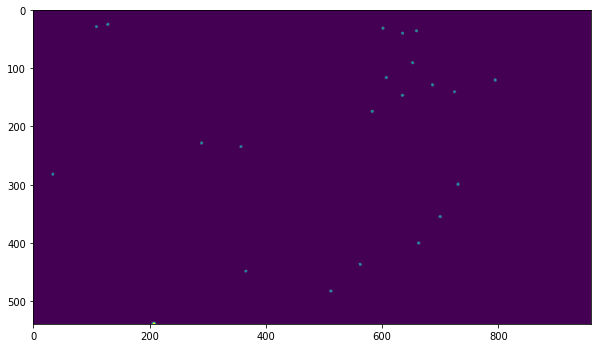

In [218]:
plt.figure(figsize = (10, 20))
plt.imshow(a)
t = x_train_resized[850]
plt.figure(figsize=(10, 20))
plt.imshow(t.reshape(t.shape[0], t.shape[1]), cmap = 'gray')
gt = y_train[850]
plt.figure(figsize=(10, 20))
plt.imshow(gt.reshape(gt.shape[0], gt.shape[1]))

In [ ]:
# x_train = x_train.tolist()
x1_train = []
x1_val = []

In [181]:
len(resized_img)

450

In [ ]:
def resize_img(x1):
  x2 = []
  for i in range(x1.shape[0]):
    x2.append(cv2.resize(x1[i, :, :], (960, 540)))
  x2 = np.array(x2)
  for i in range(x2.shape[0]):
    _, x2[i,:,:] = cv2.threshold(x2[i,:,:], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return x2 



In [219]:
x1 = y_train
x2 = resize_img(x1.astype('uint8'))
x2 = np.reshape(x2, (x2.shape[0], x2.shape[1], x2.shape[2]))

In [ ]:
x2.shape

(300, 540, 960)

In [ ]:
x1 = np.absolute(pred) * 255
x2 = resize_img(x1.astype('uint8'))
x2 = np.reshape(x2, (x2.shape[0], x2.shape[1], x2.shape[2]))

In [ ]:
def densitytogtConv(x, filters, kernel_size = (2, 2), strides = 1):
  c = tf.keras.layers.Conv2D(filters, kernel_size, strides)(x)
  c = tf.keras.layers.Conv2D(filters, kernel_size, strides)(c)
  b = tf.keras.layers.BatchNormalization()(c)
  m = tf.keras.layers.MaxPool2D((2, 2))(b)
  return m

def densitytogtFc(x):
  f1 = tf.keras.layers.Dense(32, activation='relu')(x)
  d = tf.keras.layers.Dropout(0.2)(f1)
  f2 = tf.keras.layers.Dense(16, activation='relu')(d)
  f3 = tf.keras.layers.Dense(1, activation='softplus')(f2)
  return f3

def densitytogt():
  f = [4, 4, 8, 8, 16]
  inp = tf.keras.layers.Input((540, 960))
  r = tf.keras.layers.Reshape((540, 960, 1))(inp)
  m1 = densitytogtConv(r, f[0])
  m2 = densitytogtConv(m1, f[1])
  m3 = densitytogtConv(m2, f[2])
  m4 = densitytogtConv(m3, f[3])
  m5 = densitytogtConv(m4, f[4])
  fl = tf.keras.layers.Flatten()(m5)
  d = tf.keras.layers.Dropout(0.2)(fl)
  output = densitytogtFc(d)
  return tf.keras.Model(inp, output)

In [ ]:
reg = densitytogt()

In [ ]:
reg.summary()

In [ ]:
reg.compile(optimizer='adam', loss = 'mse')

In [ ]:
reg.fit(x2, np.array(gt_train, dtype = 'float32'), batch_size=16, epochs = 20, shuffle = True)

Epoch 1/20
225/225 [==============================] - 10s 41ms/step - loss: 112.2683
Epoch 2/20
225/225 [==============================] - 9s 41ms/step - loss: 13.9943
Epoch 3/20
225/225 [==============================] - 9s 41ms/step - loss: 9.5834
Epoch 4/20
225/225 [==============================] - 9s 41ms/step - loss: 7.1252
Epoch 5/20
225/225 [==============================] - 9s 41ms/step - loss: 5.0073
Epoch 6/20
225/225 [==============================] - 9s 41ms/step - loss: 4.6373
Epoch 7/20
225/225 [==============================] - 9s 41ms/step - loss: 3.1598
Epoch 8/20
225/225 [==============================] - 9s 41ms/step - loss: 3.3438
Epoch 9/20
225/225 [==============================] - 9s 41ms/step - loss: 2.8104
Epoch 10/20
225/225 [==============================] - 9s 41ms/step - loss: 2.6059
Epoch 11/20
225/225 [==============================] - 9s 41ms/step - loss: 2.2506
Epoch 12/20
225/225 [==============================] - 9s 41ms/step - loss: 1.9843
Epoch 13/

In [ ]:
reg.save("/content/gdrive/MyDrive/fdst/densitytogtbest.h5")

In [ ]:
reg = tf.keras.models.load_model("/content/gdrive/MyDrive/fdst/densitytogt.h5")

In [220]:
gt_preds = reg.predict(x2[800:860])

In [221]:
target = gt_train[800:860]

In [222]:
for i in range(len(target)):
  print((gt_preds[i], target[i]))

(array([18.060068], dtype=float32), 22)
(array([17.825937], dtype=float32), 22)
(array([17.686739], dtype=float32), 22)
(array([18.241453], dtype=float32), 22)
(array([18.050474], dtype=float32), 22)
(array([17.602654], dtype=float32), 22)
(array([18.03951], dtype=float32), 22)
(array([18.197165], dtype=float32), 22)
(array([17.783508], dtype=float32), 22)
(array([17.636292], dtype=float32), 22)
(array([17.970015], dtype=float32), 22)
(array([17.895586], dtype=float32), 22)
(array([18.062025], dtype=float32), 22)
(array([18.111948], dtype=float32), 22)
(array([17.751078], dtype=float32), 22)
(array([17.821068], dtype=float32), 22)
(array([18.214811], dtype=float32), 22)
(array([17.836843], dtype=float32), 22)
(array([18.197023], dtype=float32), 22)
(array([17.944536], dtype=float32), 22)
(array([18.208464], dtype=float32), 23)
(array([18.135069], dtype=float32), 23)
(array([18.357103], dtype=float32), 23)
(array([18.329308], dtype=float32), 23)
(array([18.397562], dtype=float32), 23)
(

In [ ]:
np.mean(np.abs(target - gt_preds))

4.988132804870605

**Results of CodeWalk**

In [ ]:
y_train = []
x_train = []